<a href="https://colab.research.google.com/github/maribecrurod-art/Bootstrap-Proyect/blob/main/miniexperimento7_Mariana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#   Taller: Encoder Transformer vs LSTM
#   Mini-Experimento 7: Control positivo
Mariana Belén Cruz Rodríguez

In [18]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

np.set_printoptions(precision=4, suppress=True)
np.random.seed(42)

In [19]:
# SIMULACIÓN DE DATOS CLIMÁTICOS


# Simulación de 30 días con 3 variables: Temperatura, Humedad, Precipitación
dias = 30
X = np.zeros((dias, 3))
X[:,0] = 25 + np.sin(np.linspace(0, 3*np.pi, dias)) * 5       # temperatura
X[:,1] = 0.6 + np.cos(np.linspace(0, 2*np.pi, dias)) * 0.2    # humedad
X[:,2] = np.random.uniform(0, 5, dias)                        # precipitación

# Variable objetivo: temperatura del siguiente día (ruido + desplazamiento)
y = np.roll(X[:,0], -1)
y[-1] = y[-2]  # último día igual que el anterior

print("Datos simulados (X[0:5]):\n", np.round(X[:5],3))
print("\nEjemplo de y[0:5]:", np.round(y[:5],3))


Datos simulados (X[0:5]):
 [[25.     0.8    1.873]
 [26.597  0.795  4.754]
 [28.026  0.782  3.66 ]
 [29.138  0.759  2.993]
 [29.818  0.729  0.78 ]]

Ejemplo de y[0:5]: [26.597 28.026 29.138 29.818 29.993]


In [20]:
def positional_encoding(L, d):
    PE = np.zeros((L, d))
    for t in range(L):
        for i in range(0, d, 2):
            denom = np.power(10000, 2*i/d)
            PE[t, i] = np.sin((t+1)/denom)
            if i+1 < d:
                PE[t, i+1] = np.cos((t+1)/denom)
    return PE


In [21]:

# FUNCIONES DEL TRANSFORMER

def layer_norm(X, eps=1e-8):
    mean = X.mean(axis=1, keepdims=True)
    std = X.std(axis=1, keepdims=True)
    return (X - mean) / (std + eps)

def feed_forward(Y):
    W1 = np.array([
        [0.5, -0.2, 0.1],
        [0.3, 0.4, -0.1],
        [-0.4, 0.2, 0.5],
        [0.2, -0.3, 0.2]
    ])
    b1 = np.array([0.1, 0.0, -0.05])
    W2 = np.array([
        [0.6, -0.1, 0.2, 0.0],
        [-0.2, 0.5, 0.1, 0.3],
        [0.4, 0.0, -0.3, 0.2]
    ])
    b2 = np.array([0.05, 0.0, 0.02, -0.01])

    z1 = Y @ W1 + b1
    a1 = np.maximum(0, z1)
    o2 = a1 @ W2 + b2
    return o2

def transformer_output(X, use_PE=True):
    """Versión paso a paso del Transformer simplificado"""
    # proyección lineal de entrada
    W_in = np.array([
        [0.2, 0.5, -0.1],
        [0.4, -0.3, 0.2],
        [-0.2, 0.6, 0.3],
        [0.1, 0.2, 0.4]
    ])
    b_in = np.array([0.1, 0.0, -0.1, 0.05])
    E = X @ W_in.T + b_in

    if use_PE:
        PE = positional_encoding(E.shape[0], E.shape[1])
        Z = E + PE
    else:
        Z = E.copy()

    Wq = np.array([[1,0],[0,1],[1,0],[0,1]])
    Wk = Wq.copy()
    Wv = np.array([[1,0],[0,1],[0,1],[1,0]])

    Q = Z @ Wq
    K = Z @ Wk
    V = Z @ Wv

    scores = Q @ K.T / np.sqrt(K.shape[1])
    weights = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
    attn_output = weights @ V

    proj = np.repeat(attn_output, 2, axis=1)
    S = Z + proj
    Y = layer_norm(S)

    O2 = feed_forward(Y)
    U = layer_norm(Y + O2)

    h_out = U.mean(axis=0)
    w_fin = np.array([0.7, -0.2, 0.4, 0.1])
    b_fin = 0.05
    y_hat = h_out @ w_fin + b_fin
    return y_hat

In [22]:
# FUNCIÓN AUXILIAR

def shuffle_sequences(X):
    """Baraja internamente la secuencia temporal"""
    X_shuf = X.copy()
    np.random.shuffle(X_shuf)
    return X_shuf

In [23]:
#  MODELADO LSTM (control positivo)


def preparar_datos(X, y, window=5):
    Xs, ys = [], []
    for i in range(len(X)-window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = preparar_datos(X, y, window=5)
print("\nFormas:", X_seq.shape, y_seq.shape)

def entrenar_LSTM(X_train, y_train, epochs=80):
    model = Sequential([
        LSTM(16, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, verbose=0)
    return model



Formas: (25, 5, 3) (25,)


In [24]:
# Entrenamos LSTM con secuencias ordenadas
lstm_model = entrenar_LSTM(X_seq, y_seq)

# Preparamos secuencias barajadas
X_shuf_seq = np.array([shuffle_sequences(x) for x in X_seq])
lstm_mse_ord = lstm_model.evaluate(X_seq, y_seq, verbose=0)
lstm_mse_shuf = lstm_model.evaluate(X_shuf_seq, y_seq, verbose=0)

# Transformer sin y con PE
y_hat_noPE_ord = transformer_output(X, use_PE=False)
y_hat_noPE_shuf = transformer_output(shuffle_sequences(X), use_PE=False)
y_hat_PE_ord = transformer_output(X, use_PE=True)
y_hat_PE_shuf = transformer_output(shuffle_sequences(X), use_PE=True)

# Convertimos a MSE (respecto al promedio real)
y_mean = y.mean()
mse_noPE_ord = mean_squared_error([y_mean], [y_hat_noPE_ord])
mse_noPE_shuf = mean_squared_error([y_mean], [y_hat_noPE_shuf])
mse_PE_ord = mean_squared_error([y_mean], [y_hat_PE_ord])
mse_PE_shuf = mean_squared_error([y_mean], [y_hat_PE_shuf])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


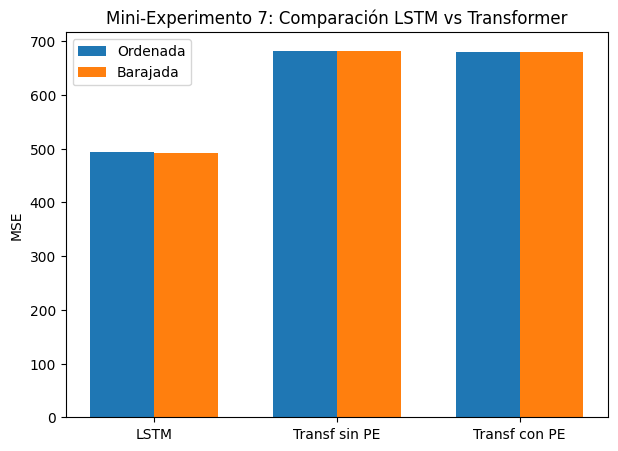

LSTM: ΔMSE = -1.502472
Transf sin PE: ΔMSE = 0.000000
Transf con PE: ΔMSE = -1.141406

Esperado:
 - LSTM → alta sensibilidad (Δ grande)
 - Transformer sin PE → insensible (Δ pequeño)
 - Transformer con PE → sensible (Δ grande)


In [25]:
# RESULTADOS

labels = ['LSTM', 'Transf sin PE', 'Transf con PE']
mse_ord = [lstm_mse_ord, mse_noPE_ord, mse_PE_ord]
mse_shuf = [lstm_mse_shuf, mse_noPE_shuf, mse_PE_shuf]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, mse_ord, width, label='Ordenada')
plt.bar(x + width/2, mse_shuf, width, label='Barajada')
plt.ylabel('MSE')
plt.title('Mini-Experimento 7: Comparación LSTM vs Transformer')
plt.xticks(x, labels)
plt.legend()
plt.show()

# ΔMSE esperado
for lbl, (mo, ms) in zip(labels, zip(mse_ord, mse_shuf)):
    print(f"{lbl}: ΔMSE = {ms - mo:.6f}")

print("\nEsperado:")
print(" - LSTM → alta sensibilidad (Δ grande)")
print(" - Transformer sin PE → insensible (Δ pequeño)")
print(" - Transformer con PE → sensible (Δ grande)")


Para el ejercicio2: implemente el encoder transformer basado en 4_taller bloques_transformer. Una vez diseñada la arquitectura, simule por 3 meses las 3 variables climáticas cada 10 minutos. Use el 70% de los datos para entrenamiento y el resto para testeo.

In [26]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

Datos simulados: (12960, 3)


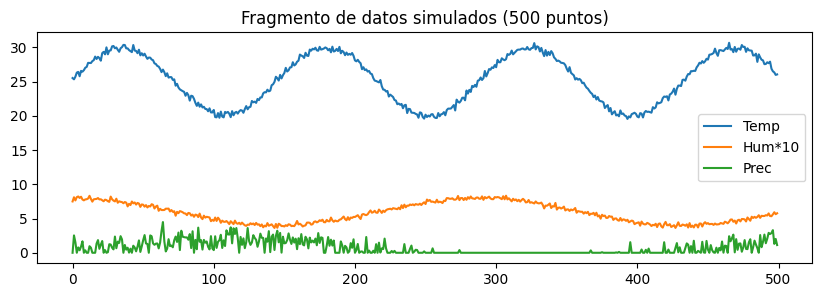

In [27]:

# Simulación de datos climáticos


# 3 meses ≈ 90 días -> 90*24*6 = 12960 muestras (cada 10 min)
t_total = 90 * 24 * 6
t = np.arange(t_total) * (10/60)  # tiempo en horas

# Simulamos 3 variables climáticas con patrones distintos
temperatura = 25 + 5*np.sin(2*np.pi*t/24) + np.random.normal(0,0.3,len(t))
humedad = 0.6 + 0.2*np.cos(2*np.pi*t/48) + np.random.normal(0,0.02,len(t))
precipitacion = np.clip(2*np.sin(2*np.pi*t/72)+np.random.normal(0,1,len(t)), 0, None)

data = np.vstack([temperatura, humedad, precipitacion]).T
print("Datos simulados:", data.shape)

plt.figure(figsize=(10,3))
plt.plot(data[:500,0], label="Temp")
plt.plot(data[:500,1]*10, label="Hum*10")
plt.plot(data[:500,2], label="Prec")
plt.legend(); plt.title("Fragmento de datos simulados (500 puntos)")
plt.show()


In [28]:
# 2. Preparación de secuencias para predicción


window = 72  # ventana de 72 pasos (~12 horas)
horizon = 1  # predicción a un paso adelante

X, y = [], []
for i in range(len(data)-window-horizon):
    X.append(data[i:i+window])
    y.append(data[i+window+horizon-1, 0])  # predecir temperatura
X = np.array(X)
y = np.array(y)
print("X:", X.shape, "y:", y.shape)


X: (12887, 72, 3) y: (12887,)


In [29]:
# entrenamiento / testeo (70/30)


n_train = int(0.7*len(X))
X_train, X_test = X[:n_train], X[n_train:]
y_train, y_test = y[:n_train], y[n_train:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=128)

In [30]:
#Encoder Transformer


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

class EncoderTransformer(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128):
        super().__init__()
        self.input_proj = nn.Linear(input_dim, d_model)
        self.pos_enc = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(d_model, 1)
    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_enc(x)
        encoded = self.encoder(x)
        # Promedio temporal (pooling)
        pooled = encoded.mean(dim=1)
        out = self.fc_out(pooled)
        return out

Época 01 | Train: 273.47218 | Test: 98.06500
Época 02 | Train: 38.81149 | Test: 13.17813
Época 03 | Train: 6.02186 | Test: 1.62505
Época 04 | Train: 0.74504 | Test: 0.42029
Época 05 | Train: 0.27784 | Test: 0.24839
Época 06 | Train: 0.21630 | Test: 0.43277
Época 07 | Train: 0.16989 | Test: 0.28121
Época 08 | Train: 0.17065 | Test: 0.47994
Época 09 | Train: 0.17731 | Test: 0.29378
Época 10 | Train: 0.14647 | Test: 0.47776
Época 11 | Train: 0.15304 | Test: 0.24491
Época 12 | Train: 0.13966 | Test: 0.33642
Época 13 | Train: 0.16357 | Test: 0.36199
Época 14 | Train: 0.15064 | Test: 0.11856
Época 15 | Train: 0.16126 | Test: 0.16453
Época 16 | Train: 0.14313 | Test: 0.36601
Época 17 | Train: 0.15851 | Test: 0.38102
Época 18 | Train: 0.14445 | Test: 0.13853
Época 19 | Train: 0.13011 | Test: 0.30397
Época 20 | Train: 0.14692 | Test: 0.22517


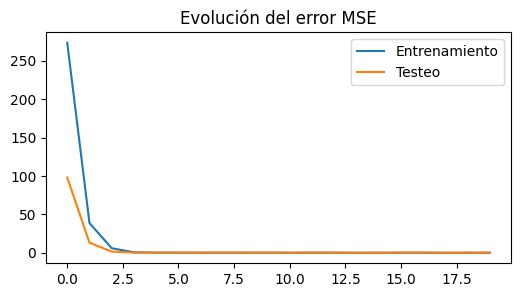

In [31]:
# Entrenamiento


device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = EncoderTransformer(input_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            total_loss += criterion(pred, yb).item()
    return total_loss / len(loader)

n_epochs = 20
train_losses, test_losses = [], []
for epoch in range(n_epochs):
    l_train = train_epoch(model, train_dl)
    l_test = eval_epoch(model, test_dl)
    train_losses.append(l_train)
    test_losses.append(l_test)
    print(f"Época {epoch+1:02d} | Train: {l_train:.5f} | Test: {l_test:.5f}")

plt.figure(figsize=(6,3))
plt.plot(train_losses, label="Entrenamiento")
plt.plot(test_losses, label="Testeo")
plt.legend(); plt.title("Evolución del error MSE")
plt.show()

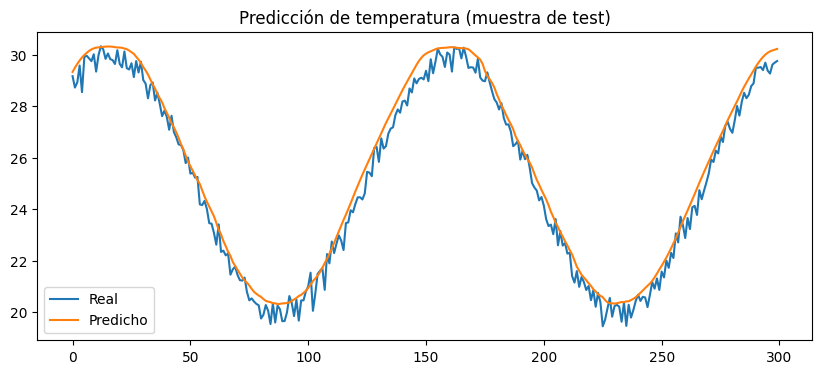

In [32]:
#  Predicción y visualización

model.eval()
with torch.no_grad():
    y_pred = model(X_test.to(device)).cpu().numpy().flatten()

plt.figure(figsize=(10,4))
plt.plot(y_test.numpy()[:300], label="Real")
plt.plot(y_pred[:300], label="Predicho")
plt.title("Predicción de temperatura (muestra de test)")
plt.legend()
plt.show()

In [33]:
mse = ((y_pred - y_test.numpy().flatten())**2).mean()
mae = np.abs(y_pred - y_test.numpy().flatten()).mean()
print(f"MSE final: {mse:.6f}")
print(f"MAE final: {mae:.6f}")


MSE final: 0.225140
MAE final: 0.395980
